# Reproducibility assessment of read alignment tools
## This is a draft (should be adapted once the naming convention is correct)

In [72]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from natsort import natsorted, natsort_keygen
import re

In [145]:
working_directory="/Users/peicer/Desktop/reproducibility/new_csv_results2/"

sample_ids=["ERR009308", 
            "ERR009309", 
            "ERR009332", 
            "ERR009345", 
            "ERR013101"]

rep_types=["both1", "both2", "both3", "sh1", "sh2", "sh3", "rc"]

In [146]:
# working_directory should contain a separate folder for each tools
tools = sorted([entry.name for entry in os.scandir(working_directory) if entry.is_dir()])

print(tools)

['bowtie2', 'bwa2', 'hisat2', 'minimap2', 'ngm', 'smalt', 'snap', 'subread']


In [147]:
csv_files = glob.glob(f'{working_directory}'+"/*/"+"/*.csv")
# csv_files


In [148]:
dataframes = []

for file in csv_files:
    df = pd.read_csv(file)
    filename = os.path.splitext(os.path.basename(file))[0]
    tool_name = os.path.basename(os.path.dirname(file))
    df['tool'] = tool_name
    
    for rep_type in rep_types:
        if rep_type in filename:
            df['replicate'] = rep_type
            break
    
    for sid in sample_ids:
        if sid in filename:
            df['sampID'] = sid
        
    dataframes.append(df)
    
df_combined = pd.concat(dataframes)
df_combined = df_combined.sort_values(["tool", "sampID" ,"replicate"], key=natsort_keygen())
features = df_combined['FEATURE'].unique()

In [149]:
df_combined.head()
# print(avg_df_combined.head())
# df_combined[(df_combined['FEATURE'] == 'Identical') & (df_combined['tool'] == 'bwa2')
#            & (df_combined['sampID'] == 'ERR009308')]

,FEATURE,READS,PERCENTAGE,tool,replicate,sampID
0,Total_reads,14587316,100.0,bowtie2,both1,ERR009308
1,Mapped_reads,14409166,98.779,bowtie2,both1,ERR009308
2,Unambigous_type1,11815780,82.002,bowtie2,both1,ERR009308
3,Unambigous_type2,10063816,69.843,bowtie2,both1,ERR009308
4,Common_unambiguous,9966062,69.165,bowtie2,both1,ERR009308


In [166]:
df_pivot = df_combined.pivot(index=['tool', 'replicate', 'sampID'], values='PERCENTAGE', columns='FEATURE')
df = df_pivot.reset_index()
df['repType'] = df['replicate'].apply(lambda x: re.sub(r'\d+', '', x))
avg_df = df.groupby(['repType', 'sampID', 'tool'])[features].mean().reset_index()
avg_df['non-identical'] = 100-avg_df['Identical']


avg_df.head()
avg_df[(avg_df['repType'] == 'rc') & (avg_df['tool'] == 'bowtie2')]


FEATURE,repType,sampID,tool,Total_reads,Mapped_reads,Unambigous_type1,Unambigous_type2,Common_unambiguous,Inconsistent_type1,Inconsistent_type2,Identical,Consistent_global_inconsistent_local,Inconsistent_global,Multi_mapped,non-identical
40,rc,ERR009308,bowtie2,100.0,98.779,82.002,69.843,69.165,0.310,0.178,95.527,0.536,3.110,0.340,4.473
48,rc,ERR009309,bowtie2,100.0,98.776,80.544,67.827,67.105,0.266,0.149,95.631,0.411,3.181,0.361,4.369
56,rc,ERR009332,bowtie2,100.0,99.071,80.792,67.808,67.109,0.203,0.129,95.724,0.408,3.167,0.370,4.276
64,rc,ERR009345,bowtie2,100.0,98.840,81.838,69.126,68.491,0.130,0.114,97.768,0.596,1.168,0.223,2.232
72,rc,ERR013101,bowtie2,100.0,98.273,80.755,72.952,72.116,0.121,0.101,95.046,3.339,1.253,0.140,4.954


In [186]:
# bar plot with distribution bar
def plot_bar_err(data_df, info, category, label, line, val):
#     plt.figure()
    plt.figure(figsize=(10, 6))

    ax=sns.barplot(x = "tool", y = info, hue = category, data = data_df,
                palette = 'Set1',
                order = tools, 
                capsize=0.05,  errwidth=2, ci='sd')
    if line:
        ax.axhline(val, color='black', linestyle='--')
    ax.set(xlabel='tools', ylabel=label)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.legend(bbox_to_anchor=(1, 1))

In [260]:
def plot_bar_err2(data_df, category, xval, label):
    
    
    df_melted = data_df.melt(category, var_name='values')
    print(df_melted[df_melted['tool'] == 'bowtie2'])
    
    sns.set(style='whitegrid')
    plt.figure(figsize=(8,6))
    ax=sns.catplot(x=xval, y='value', hue='values', col='repType', data=df_melted,
                  palette='Set1',
                  order=tools, 
                  capsize=0.05, errwidth=2, ci='sd', kind='bar')
    
    ax.set(xlabel='tools', ylabel=label)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
#     ax.legend(bbox_to_anchor=(1, 1))

<Figure size 576x432 with 0 Axes>

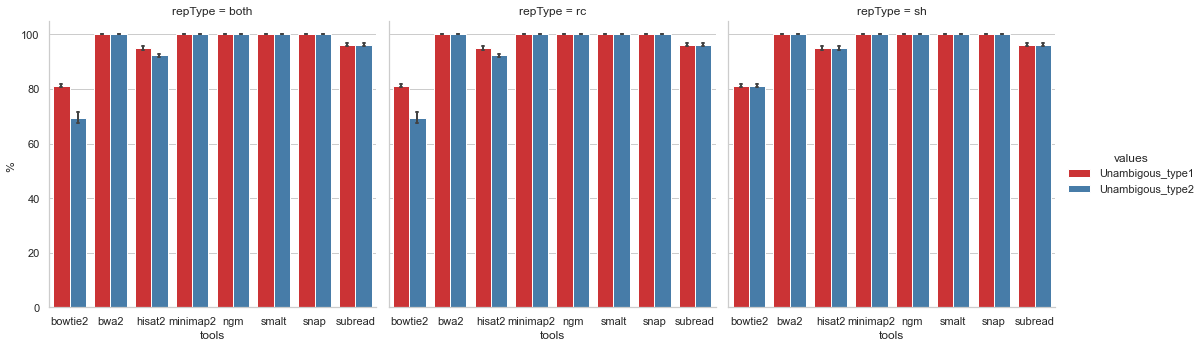

In [261]:
plot_bar_err2(avg_df[['repType', 'sampID', 'tool', 'Unambigous_type1', 'Unambigous_type2']], 
              ['tool', 'repType', 'sampID'], 'tool', '% ')


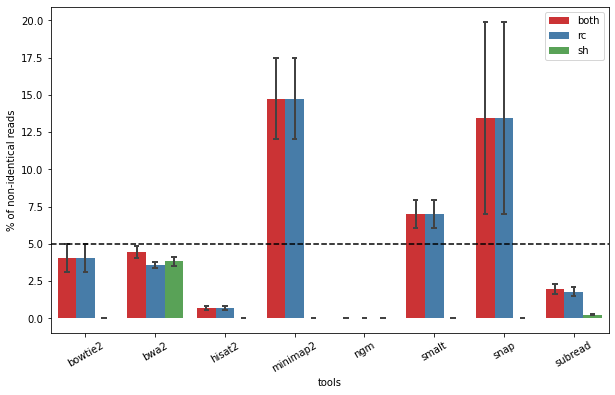

In [182]:
plot_bar_err(avg_df, 'non-identical', '% of non-identical reads', True, 5)


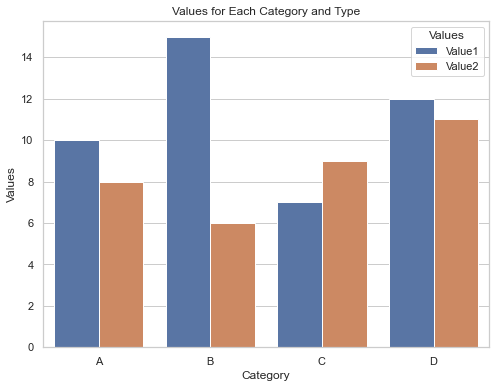

In [207]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame
data = {
    'Category': ['A', 'B', 'C', 'D'],
    'Type': ['rc', 'sh', 'rc', 'sh'],
    'Value1': [10, 15, 7, 12],
    'Value2': [8, 6, 9, 11]
}
df = pd.DataFrame(data)

# Reshaping the DataFrame for plotting
df_melted = df.melt(['Category', 'Type'], var_name='Values')

# Creating the bar plot using Seaborn
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='value', hue='Values', data=df_melted, ci=None)

# Adding labels and title
plt.xlabel('Category')
plt.ylabel('Values')
plt.title('Values for Each Category and Type')

# Displaying the plot
plt.show()
